# Get Started (GPU memory eco version)

Last update: December 9th (2024) Hajime Kawahara 

This is a GPU memory friendly version of "get started"!  
First, we recommend 64-bit if you do not think about numerical errors. Use jax.config to set 64-bit. 
(But note that 32-bit is sufficient in most cases. Consider to use 32-bit (faster, less device memory) for your real use case.) 

In [1]:
from jax import config
config.update("jax_enable_x64", True)

One approach to reducing device memory usage is to calculate the opacity layer by layer and advance the radiative transfer by one layer at a time. To achieve this, it is necessary to integrate the opacity calculator (`opa`) and the radiative transfer (`art`), leading to the use of the `opart` class (opa + art). Here, we demonstrate the calculation of a pure absorption emission spectrum using `opart`.

## 1. Computes an Emission Spectrum using `opart`

The user needs to define a class, `OpaLayer`, that specifies how to calculate opacity for each layer. The `OpaLayer` class must define at least an `__init__` method and a `__call__` method. Additionally, `self.nu_grid` must be defined. The `__call__` method should take the parameters of a layer as input and return the optical depth (delta tau) for that layer.

In [2]:
from exojax.spec.opacalc import OpaPremodit
from exojax.spec.layeropacity import single_layer_optical_depth
from exojax.utils.grids import wavenumber_grid
from exojax.spec.api import MdbExomol
from exojax.utils.astrofunc import gravity_jupiter


class OpaLayer:
    # user defined class, needs to define self.nugrid
    def __init__(self, Nnus=200000):
        self.nu_grid, self.wav, self.resolution = wavenumber_grid(
            1900.0, 2300.0, Nnus, unit="cm-1", xsmode="premodit"
        )
        self.mdb_co = MdbExomol(".database/CO/12C-16O/Li2015", nurange=self.nu_grid)
        self.opa_co = OpaPremodit(
            self.mdb_co,
            self.nu_grid,
            auto_trange=[500.0, 1500.0],
            dit_grid_resolution=1.0,
            allow_32bit=True
        )
        self.gravity = gravity_jupiter(1.0, 10.0)


    def __call__(self, params):
        temperature, pressure, dP, mixing_ratio = params
        xsv_co = self.opa_co.xsvector(temperature, pressure)
        dtau_co = single_layer_optical_depth(
            xsv_co, dP, mixing_ratio, self.mdb_co.molmass, self.gravity
        )
        return dtau_co

/home/kawahara/exojax/src/exojax/spec/dtau_mmwl.py:13: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


Do not put  `@partial(jit, static_argnums=(0,))` on ``__call__``.  This is not necessary and makes the code significantly slow.

Next, the user will utilize the `OpaLayer` class in the `Opart` class. Here, since the goal is to calculate pure absorption emission, the `OpartEmisPure` class will be used. (Remember that if `opa` and `art` are separated, the `ArtEmisPure` class would have been used instead.)

In [3]:
from exojax.spec.opart import OpartEmisPure

opalayer = OpaLayer(Nnus=200000)
opart = OpartEmisPure(opalayer, pressure_top=1.0e-5, pressure_btm=1.0e1, nlayer=200, nstream=8)
opart.change_temperature_range(400.0, 1500.0)


xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: xsmode=premodit
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order
HITRAN exact name= (12C)(16O)
radis engine =  vaex


/home/kawahara/exojax/src/exojax/utils/molname.py:197: FutureWarning: e2s will be replaced to exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(


Molecule:  CO
Isotopologue:  12C-16O
Background atmosphere:  H2
ExoMol database:  None
Local folder:  .database/CO/12C-16O/Li2015
Transition files: 
	 => File 12C-16O__Li2015.trans
Broadening code level: a0


/home/kawahara/exojax/src/radis/radis/api/exomolapi.py:685: AccuracyWarning: The default broadening parameter (alpha = 0.07 cm^-1 and n = 0.5) are used for J'' > 80 up to J'' = 152
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/opacalc.py:215: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 485.7803992045456 - 1514.171191195336 K
OpaPremodit: Tref_broadening is set to  866.0254037844389 K
# of reference width grid :  2
# of temperature exponent grid : 2


uniqidx: 0it [00:00, ?it/s]


Premodit: Twt= 1108.7151960064205 K Tref= 570.4914318566549 K
Making LSD:|####################| 100%


Here, somewhat abruptly, we define a function to update a layer. This function simply calls `update_layer` within `opart` and returns its output along with `None`. You might wonder why you need to define such a function yourself. To get a bit technical, this function is used with `jax.lax.scan` when updating layers. However, if it is defined inside a class, XLA will recompile every time the parameters change, leading to a performance slowdown. For this reason, in the current implementation, users are required to define this function outside the class. This implementation may be revisited and revised in the future.

In [4]:
def layer_update_function(carry_tauflux, params):
    carry_tauflux = opart.update_layer(carry_tauflux, params)
    return carry_tauflux, None

Now, let’s define the temperature and mixing ratio profiles (in the same way as for `art`) and calculate the flux. Define the `layer_parameter` input, which is a list of parameters for all layers. The temperature profile must be specified as the first element (index 0). For the remaining elements, arrange them in the same order as used in the user-defined `OpaLayer`.

In [5]:
temperature = opart.clip_temperature(opart.powerlaw_temperature(900.0, 0.1))
mixing_ratio = opart.constant_mmr_profile(0.01)
layer_params = [temperature, opart.pressure, opart.dParr, mixing_ratio]
flux = opart(layer_params, layer_update_function)

The spectrum has now been calculated. Let’s plot it. In this example, we calculate 200,000 wavenumber grid points across 200 layers. Even if the GPU you’re using has only 8 GB of device memory, such as an RTX 2080, it should be sufficient to perform the computation.

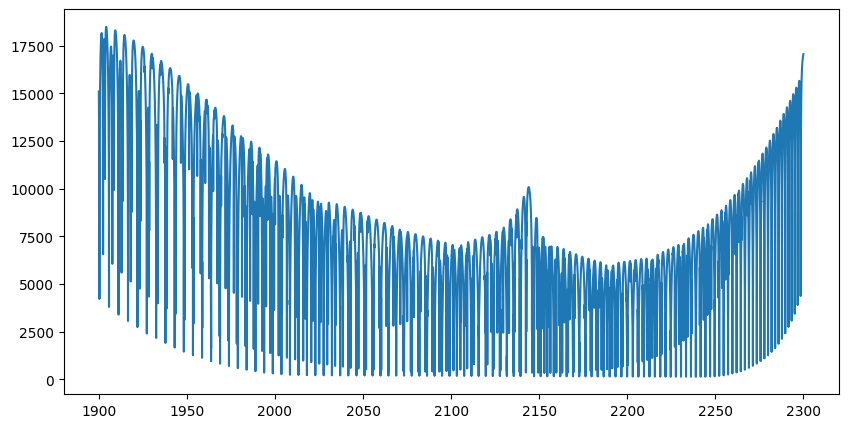

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(opalayer.nu_grid, flux)
plt.show()    